# COURSE: A deep understanding of deep learning
## SECTION: CodeChallenge: how many units?
### LECTURE: Denoising MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import sys

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# # import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# # don't need labels!
# data = data[:,1:]

# # normalize the data to a range of [0 1]
# dataNorm = data / np.max(data)

# # convert to tensor
# dataT = torch.tensor( dataNorm ).float()

import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data
train_labels = mnist_train.targets
test_data = mnist_test.data
test_labels = mnist_test.targets

# reshape data to 2D tensor
train_data = train_data.reshape(-1, 28*28).float()
test_data = test_data.reshape(-1, 28*28).float()

labels = torch.cat((train_labels, test_labels), dim=0)
data = torch.cat((train_data, test_data), dim=0)

# extract labels (number IDs) and remove from data
# labels = data[:,0]
# data   = data[:,1:]

dataNorm = data / np.max(data.numpy())

labelsPy = labels.numpy()
dataPy = data.numpy()

print(dataNorm.shape)
print(labels.shape)

dataT = torch.tensor(dataNorm)

torch.Size([70000, 784])
torch.Size([70000])


/tmp/ipykernel_359611/4270108361.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT = torch.tensor(dataNorm)


# Create the DL model

In [3]:
# create a class for the model
def createTheMNISTAE(nEncoding, nLatent):

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,nEncoding)
      
      ### encoder layer
      self.enc = nn.Linear(nEncoding,nLatent)

      ### latent layer
      self.lat = nn.Linear(nLatent,nEncoding)

      ### decoder layer
      self.dec = nn.Linear(nEncoding,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE(10,5)

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


# Create a function that trains the model

In [5]:
def function2trainTheModel(dataT, nEncoding, nLatent):

  # number of epochs
  numepochs = 10000
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE(nEncoding,nLatent)

  # initialize losses
  losses = torch.zeros(numepochs)
   
  # loop over epochs
  for epochi in range(numepochs):
    
    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]
    

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net,dataT

# Run the experiment and show the results!

In [6]:
# set parameter steps 
nEncoding = np.linspace(10, 500, 12, dtype=int)
nLatent = np.linspace(5, 100, 8, dtype=int)

# create losses array
lossesArray = np.zeros((len(nEncoding), len(nLatent)))

# run experiment 
for i in range(len(nEncoding)):
  for j in range(len(nLatent)):
    percentageCompletion = (i*len(nLatent) + j) / (len(nEncoding) * len(nLatent))
    sys.stdout.write(f'\rEncoding: {nEncoding[i]}, Latent: {nLatent[j]}. {percentageCompletion:.2%} complete.')
    sys.stdout.flush()
    losses,net,dataT = function2trainTheModel(dataT, nEncoding[i], nLatent[j])
    lossesArray[i, j] = np.mean(losses[-3:].numpy())

Encoding: 10, Latent: 18. 1.04% complete.

KeyboardInterrupt: 

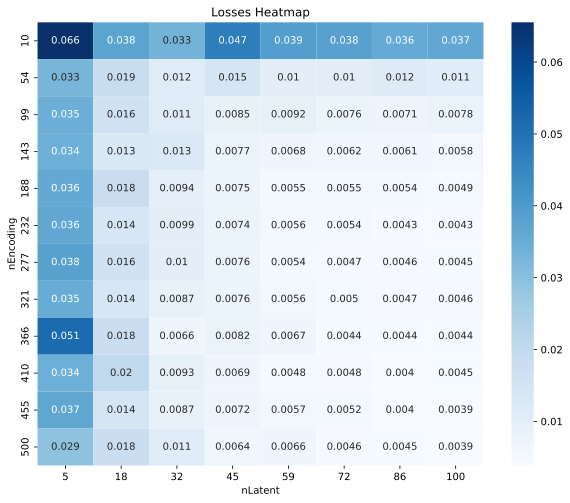

In [10]:
# visualize the losses

plt.figure(figsize=(10,8))
sns.heatmap(lossesArray, annot=True, cmap='Blues', xticklabels=nLatent, yticklabels=nEncoding)

# Set labels
plt.xlabel('nLatent')
plt.ylabel('nEncoding')
plt.title('Losses Heatmap')

# Show the plot
plt.show()

# Add noise to see a use case of an autoencoder

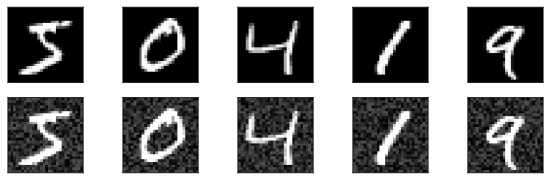

In [104]:
# grab a small set of images
X = dataT[:15,:]

# add noise
Xnoise = X + torch.rand_like(X)/3

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.show()

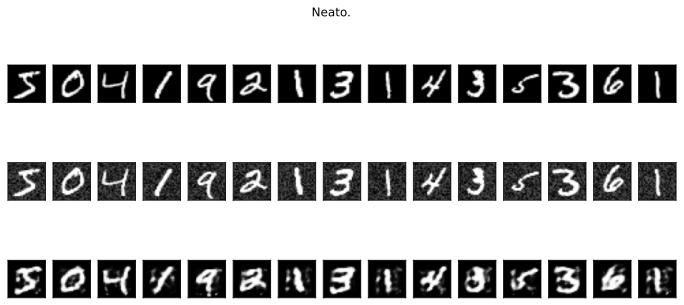

In [105]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig,axs = plt.subplots(3,15,figsize=(12,5))

for i in range(15):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.suptitle('Neato.')
plt.show()